In [ ]:
import numpy as np
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt

## Define Constants

In [ ]:
dt = 0.001 # simulation time step
fs = 1/dt # sampling rate

tk = np.arange(0, 1, dt) #PSC kernel time vector
t = np.arange(0, 60*2, dt) #simulation time vector

# spike train parameters
FR_E = 2 # Firing Rate -- Excitatory
FR_I = 5 # Firing Rate -- Inhibitory
N_E = 8000 # Population -- Excitatory
N_I = 2000 # Population -- Inhibitory

# ampa/gaba PSC kernels
Vr = -65 # Resting Membrane Potential
Ee = 0 # AMPA Reversal Potential -- Excitatory
Ei = -80 # GABA_A Reversal Potential -- Inhibitory
AMPA_tau = np.array([0.1, 2.])/1000. # AMPA Conductance Rise, Decay Time in Seconds
GABA_tau = np.array([0.5, 10.])/1000. # GABA_A Conductance Rise, Decay Time in Seconds

## Synaptic Kernel Function

In [ ]:
def syn_kernel (t, tau):
    # given a specific synaptic kernel type and time constant, this returns a
    # time series of the kernel that spans the time defined (t) in seconds
    #
    # t: time vector in seconds (e.g. t=0:0.001:5)
    # tau: t_decay or [t_rise t_decay] in seconds
    #
    # return: kernel -- the synaptic kernel
    if len(tau) != 2:
        print('Need two time constants for double exponential.')
        return np.array([])
    tpeak = tau[1]*tau[0] / (tau[1]-tau[0]) * np.log(tau[1]/tau[0])
    normf = 1/(-np.exp(-tpeak/tau[0]) + np.exp(-tpeak/tau[1])) # the normalization factor
    kernel = normf * (-np.exp(-t/tau[0])+np.exp(-t/tau[1]))
    return kernel

### PSC Kernel Plot

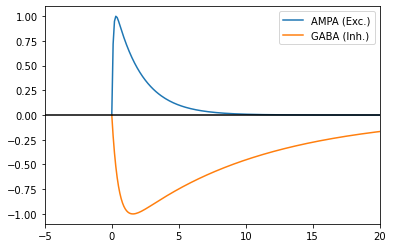

In [ ]:
tk_p = np.arange(0, 0.2, 0.0001) # kernel time vector for the plot
kA_p = syn_kernel(tk_p,AMPA_tau); # AMPA kernel for the plot
kG_p = syn_kernel(tk_p,GABA_tau); # GABA_A kernel for the plot

ax = sns.lineplot(x = tk_p*1e3, y = kA_p)
sns.lineplot(x = tk_p*1e3, y = -kG_p, ax = ax)
ax.axhline(y = 0, color = 'black')
ax.set_xlim(-5,20)
ax.legend(labels=["AMPA (Exc.)","GABA (Inh.)"])

## Poisson Spikes

In [ ]:
def pois_spikes (sim_t, dt, N_neu, FR):
    # simulate population spiking of N neurons firing at FR each, return a
    # single spike train that is the total spiking

    # mu parameter for exponential distribution
    MU = 1. / (N_neu*FR)

    # draw ISI from exp RV 
    ISI = np.random.exponential(MU, int((sim_t+2)/MU))
    spk_times = np.cumsum(ISI)
    spk_times = spk_times[spk_times<=sim_t] # potentially inefficient

    # discretize
    bins = np.arange(0, sim_t, dt) + dt/2 # make discretizing bins
    discretized, _ = np.histogram(spk_times, bins = bins, density = False)
    return discretized

### Poisson Spike Count/dt Plot

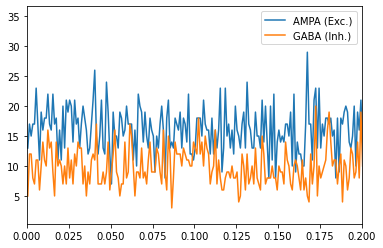

In [ ]:
spk_E = pois_spikes(t[-1]+tk[-1], dt, N_E, FR_E);
spk_I = pois_spikes(t[-1]+tk[-1], dt, N_I, FR_I);
sim_t = t[-1]+tk[-1]
bins = np.arange(0, sim_t, dt) + dt/2
ax = sns.lineplot(x = bins[:5000], y = spk_E[:5000]) # truncate to 5000(arbitrary) to save time
sns.lineplot(x = bins[:5000], y = spk_I[:5000], ax = ax) # truncate to 5000 to save time
ax.set_xlim(0,0.2)
ax.legend(labels=["AMPA (Exc.)","GABA (Inh.)"])

## Simulation

### One trial one ratio test

In [ ]:
EI_ratio = 4
kA = syn_kernel(tk,AMPA_tau)
kG = syn_kernel(tk,GABA_tau)
boost = EI_ratio / ((N_I*FR_I*sum(kG))/(N_E*FR_E*sum(kA)))
spk_E = pois_spikes(t[-1]+tk[-1], dt, N_E, FR_E);
spk_I = pois_spikes(t[-1]+tk[-1], dt, N_I, FR_I);
GE = np.convolve(spk_E, kA, 'valid') # Total Excitatory Conductance
GI = np.convolve(spk_I, kG, 'valid') * boost # Total Inhibitory Conductance
LFP_E = signal.detrend(GE, type = 'constant') * (Ee-Vr) # high-pass drift removal * potential difference
LFP_I = signal.detrend(GI, type = 'constant') * (Ei-Vr) # high-pass drift removal * potential difference
LFP = LFP_E + LFP_I

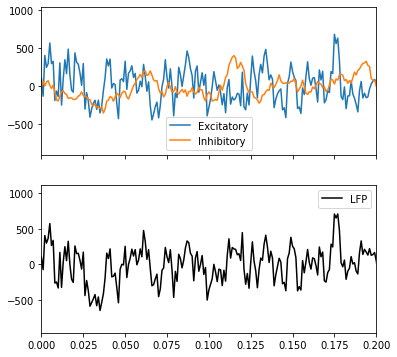

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax = sns.lineplot(x = t[:5000], y = LFP_E[:5000], ax = axes[0]) # used arbitrary length of 5000 to save time
sns.lineplot(x = t[:5000], y = LFP_I[:5000], ax = axes[0])
ax.set_xlim(0,0.2)
ax.legend(labels=["Excitatory","Inhibitory"])

ax = sns.lineplot(x = t[:5000], y = LFP[:5000], color='black', ax = axes[1]) # used arbitrary length of 5000 to save time
ax.set_xlim(0,0.2)
ax.legend(labels=["LFP"])

In [ ]:
t.shape, LFP_E.shape # array length not matched

((120000,), (119998,))